# Towards spectral super-resolution in solar absorption lines from pseudomonochromatic images

## Experiment 4. Spectral super-resolution  with Fourier Features

This is a PyTorch implementation of the image regression experiment presented in the study ["Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains"](https://bmild.github.io/fourfeat/) by Tancik et al.

### Choose envinroment, libraries and source files

#### Envinroment

In [1]:
# Attempt to import the necessary modules for Google Colab environment
try:
    # If running in Google Colab, import the drive module from google.colab
    from google.colab import drive
    # This mounts the Google Drive to the Colab VM, allowing access to its files.
    drive.mount('/content/drive')

    # Define the base path to the project folder within Google Drive
    PATH = '/content/drive/MyDrive/Colab Notebooks/FHN/assets/'
    # Concatenate the base path with specific subdirectories for source code, images, and outputs
    SRC_PATH = PATH + 'src/'  # Path to source code
    IMG_PATH = PATH + 'images/sol.h5'  # Path to a specific image file
    MODEL_PATH = PATH + 'outputs/models/SUPERFF/'  # Path to output models directory
    IMAGES_PATH = PATH + 'outputs/results/SUPERFF/images/' # Path to output images directory
    VIDEO_PATH = PATH + 'outputs/results/SUPERFF/videos/' # Path to output videos directory
    LOGS_PATH = PATH + 'outputs/results/SUPERFF/logs/' # Path to output log profiler directory

# If the google.colab module is not found (meaning not running in Google Colab),
# fallback to a local environment setup.
except ImportError:
    # Define local paths assuming the Jupyter Notebook is running in a local environment
    SRC_PATH = 'assets/src/'  # Local path to source code
    IMG_PATH = 'assets/images/sol.h5'  # Local path to a specific image file
    MODEL_PATH = 'assets/outputs/models/SUPERFF/'  # Local path to output models directory
    IMAGES_PATH = 'assets/outputs/results/SUPERFF/images/' # Path to output images directory
    VIDEO_PATH = 'assets/outputs/results/SUPERFF/videos/' # Path to output videos directory
    LOGS_PATH = 'assets/outputs/results/SUPERFF/logs/' # Path to output log profiler directory

Mounted at /content/drive


#### Libraries

In [2]:
# Import the 'sys' library to interact with the Python runtime environment.
import sys

# Import the 'copy' module from Python's standard library.
# This module provides the 'deepcopy' function, which can be used
# to create deep copies of mutable objects like dictionaries.
import copy

# Import the 'time' module to measure the time elapsed during certain operations or code execution
import time

# Import the NumPy library and rename it as np.
# NumPy is a library for numerical computing in Python and is especially useful for array operations.
import numpy as np

# Import the 'tqdm' function from the 'tqdm.auto' module for displaying progress bars in Jupyter notebooks or consoles.
from tqdm.auto import tqdm

# Import the pyplot module from the Matplotlib library and rename it as plt.
# Matplotlib is a library for creating static, interactive, and animated visualizations in Python.
import matplotlib.pyplot as plt

# Import the 'seaborn' library for data visualization. Seaborn is based on Matplotlib
# and provides a high-level interface for drawing attractive and informative statistical graphics.
import seaborn

# Import the PyTorch library for deep learning.
# PyTorch is an open-source machine learning library used for a variety of tasks,
# including classification, regression, and image generation.
import torch

# Import the functional module from nn and rename it as F.
# This module contains functions that can be used in defining operations of a neural network,
# such as activations and losses.
import torch.nn.functional as F

#### Source files

In [3]:
# Append the SRC_PATH directory to the system path to make its modules accessible.
sys.path.append(SRC_PATH)

In [4]:
# Import all functions and variables from the 'utils' module located in the 'assets/src/' directory.
from utils import (set_seed, smooth_curve, get_data, get_experiment_data,
                   plot_data, crop, time_formatter, feat_scaling, info, normalize)
from dataset import grid3D, split_data_2D
from training import train, generate_B, fourier_mapping, best_lr
from models import NeuralFieldFF

### Random seed for reproducibility

In [5]:
# Set the random seed to 42 for reproducibility.
seed = 42
set_seed(seed)

### Get the available device

#### Minimum Recommended Hardware Requirements

To perform the training within an acceptable time frame, it is highly recommended to have access to a GPU. The original experiment was conducted using the following GPU configuration:

- **CUDA Availability**: Yes
- **GPU Model**: Tesla T4
- **Total Memory**: 15360.0 MiB
- **Free Memory**: 11392.0 MiB
- **Memory Used**: 3709.0 MiB
- **Timestamp**: Tue Aug 1 07:29:13 2023

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   3709MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
+-----------------------------------------------------------------------------+
```

In [6]:
model = !nvidia-smi --query-gpu=name --format=csv,noheader
GPU = model[0]

In [7]:
# Define the 'device' variable to specify where the code will run (CPU or GPU).
# Use the GPU (CUDA) if available; otherwise, use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the available device to inform the user.
# This is useful for debugging and to ensure the code is running on the desired device.
print("Available device:", device)

Available device: cuda


### Solar images

<p align='justify'>For the PFG, we have a real spectral data cube I(x, y, λ) of the photospheric absorption line of neutral iron (that is, non-ionized) centered at 6302 Å (Fe I λ6302). Specifically, there are 21 pseudomonochromatic images, each with dimensions of 966x964 pixels, covering a large area of the Sun's surface. These images "scan" the Fe I λ6302 absorption line across 21 narrow wavelength (λ) intervals.</p>

In [8]:
# Call the 'get_data' function to read the image data from the specified path and store it in the variable 'cube'.
cube = get_data(IMG_PATH)

# Get the number of images in the cube by accessing the first dimension of its shape.
NUM_IMAGES = cube.shape[0]

# Create labels for the wavelengths. The labels are in the format 'λ = n', where n starts from 1 and goes up to NUM_IMAGES.
wl_lbls = [f'$\\lambda_{{{label + 1}}}$' for label in np.arange(0, NUM_IMAGES)]

First key: cube


In [9]:
cube.shape

(21, 966, 964)

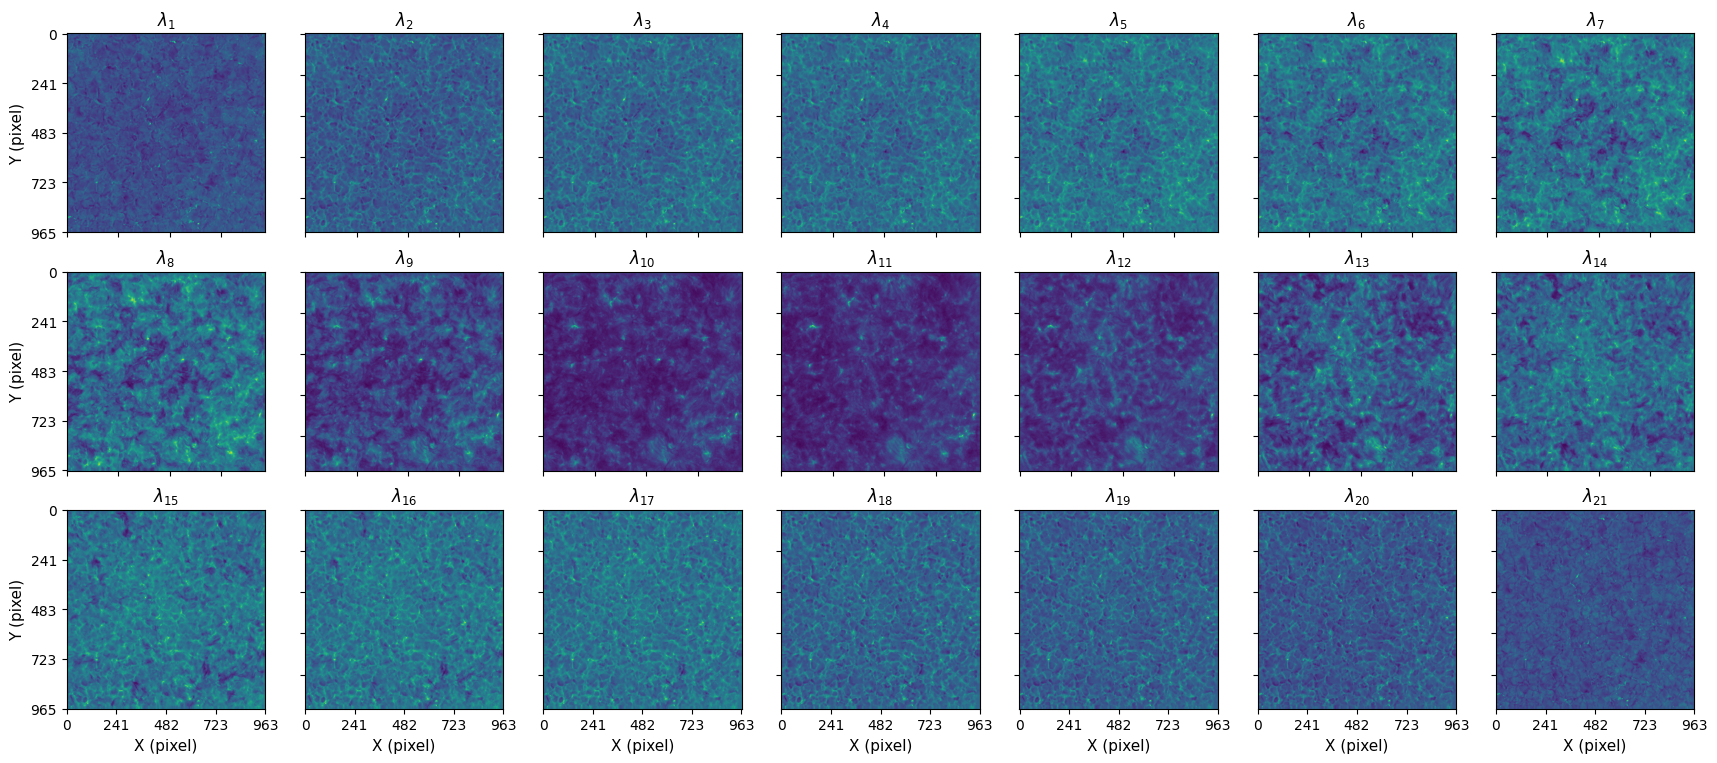

In [10]:
# Call the plot_data function to visualize the 'cube' dataset
plot_data(dataset=cube, num_columns=7,
          labels=wl_lbls, tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='solar_dataset',
          hspace=0.1, wspace=0.2)

### Experiment Settings

#### Paremeters

In [11]:
# Define a list of loss functions to be used during the training process.
# The list includes L1 loss, Mean Squared Error (MSE) loss, and Smooth L1 loss.
loss_functions = [F.l1_loss, F.mse_loss, F.smooth_l1_loss]

# Define a list of sigma values to be used for Gaussian Fourier feature mapping or other applications.
sigmas = [0.8, 10., 25.]

# Create a PyTorch tensor containing specific sigma values for different dimensions or purposes.
# The tensor is of type float32.
# sigmas.append(torch.tensor([10., 10., .8], dtype=torch.float32))
m_vector = [64, 128, 256]

In [12]:
# Comment this line for complete training or uncomment for single training
sigmas = [0.8]
sigmas.append(torch.tensor([10., 10., .8], dtype=torch.float32))
m_vector = [64, 256]

In [13]:
# Initialize an empty dictionary to store the configuration parameters for the experiment.
config = {}

# Store the hardware information (either CPU or GPU details) in the 'info' key of the config dictionary
config['HARDWARE'] = info()

# Set the index of the image to be used from the data cube.
config['IMG_INDEX'] = np.arange(0, NUM_IMAGES)

# Set the size of the image crop to be used for training.
config['CROP_SIZE'] = 512

# Set the dimension of the Fourier feature mapping matrix (M). The total number of Fourier features will be 2M.
config['M'] = m_vector

# Set the value of sigma for Gaussian Fourier feature mapping, using the fourth value from the 'sigmas' list.
config['SIGMA'] = sigmas

# Set the learning rate for the optimizer.
config['LR'] = 1e-4

# Set the loss function to be used for training, using the second function from the 'loss_functions' list.
config['LOSS'] = loss_functions[1]

# Set the number of epochs for training.
config['EPOCHS'] = 2000

#### Fourier features

<p align="justify">The first attempt will be to verify the architecture, among all the possibilities that have been recently suggested, that best approximates the pseudomonochromatic images. We use neural fields, also known as "implicit neural representations": A neural field applied to a pixelated image consists of a neural network that takes the coordinates (𝑥, 𝑦) of the pixel as inputs and outputs its RGB value (in this case, the pixel's intensity). When a trained neural field is queried to output values for all pixels, the image is reconstructed. A neural field is, therefore, a continuous and differentiable function that approximates a function defined in a space, in our case 𝐼(𝑥, 𝑦).</p>

#### Train networks with different input mappings

This time we will use only the Gaussian mapping $\gamma (\mathbf{v})$.

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$,
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $N(0,\sigma)$

In [14]:
def get_B_dict(sigmas, m_vector):
    """
    Generate a dictionary of Gaussian Fourier mapping matrices for a given list of sigma values.

    Parameters:
    - sigmas (list): A list of sigma values for which the Gaussian Fourier mapping matrices are to be generated.

    Returns:
    - dict: A dictionary where the keys are the sigma values (as strings) and the values are the corresponding Gaussian Fourier mapping matrices.
    """

    # Initialize an empty dictionary to store different Fourier mapping matrices
    B = {}

    # Loop over a list of sigma values to generate Gaussian Fourier mapping matrices
    for s in sigmas:
        # Generate a Gaussian Fourier mapping matrix with 'm' features and standard deviation 'sigma'
        # Store the generated matrix in the dictionary with a key that includes the sigma value
        for m in m_vector:
          B[f'{s}-{m}'] = generate_B(m=m, sigma=s, device=device)

    return B

# Call the function with a list of sigma values and store the resulting dictionary in 'B'
B = get_B_dict(config['SIGMA'], config['M'])

#### Obtaining the image for the experiment

In [15]:
# Retrieve one of the images from the cube dataset using the specified index from the config dictionary
images = get_experiment_data(cube)

# Crop the image to create a patch of size (CROP_SIZE x CROP_SIZE) as specified in the config dictionary
images = crop(images, config['CROP_SIZE'])

# Normalize the pixel intensity values of the image to the range [0, 1] using feature scaling
images, (min, max) = feat_scaling(images)

# Normalize the pixel intensity values of the image to the range [0, 1] using normalize
# images, (min_, max_) = normalize(images)

# Save GT image to config dictionary
config['GT_IMG'] = images

# Create an array of wavelengths ranging from config['IMG_INDEX'] array
wavelengths = config['IMG_INDEX']

# Create labels for the wavelengths. The labels are in the format 'λ_n'
lbls = [f'$\\lambda_{{{label + 1}}}$' for label in wavelengths]

#### Obtaining the grid of normalized coordinates

In [16]:
# Obtain the grid of normalized coordinates in the interval [0, 1]
coords = grid3D(images)

# Save the grid to config dictionary
config['COORDS_VAL'] = coords

#### Getting the training and test datasets

In [17]:
# Use the function to split the data into training and testing sets.
train_loader, test_loader = split_data_2D(coords, images, wavelengths, device=device, bs=4)

#### Info

In [18]:
# Downsample the coordinates by taking every other pixel along the width and height.
coords_train = coords[:, :, ::2, ::2]

# Downsample the image by taking every other pixel along the width and height.
images_train = images[:, :, ::2, ::2]

# Print the shape of the original coordinates tensor.
print(f'Coordinates: {coords.shape}')

# Print the shape of the original image tensor.
print(f'Image: {images.shape}')

# Print the shape of the downsampled coordinates tensor.
print(f'Coordinates train: {coords_train.shape}')

# Print the shape of the downsampled image tensor.
print(f'Image train: {images_train.shape}')

# Retrieve the next batch of data and labels from the test_loader
x, y, _ = next(iter(train_loader))

# Print the shape of the batch data
print(f'First batch coords: {x.shape}')

# Print the shape of the batch labels
print(f'First batch labels: {y.shape}')

Coordinates: torch.Size([21, 3, 512, 512])
Image: torch.Size([21, 1, 512, 512])
Coordinates train: torch.Size([21, 3, 256, 256])
Image train: torch.Size([21, 1, 256, 256])
First batch coords: torch.Size([4, 3, 256, 256])
First batch labels: torch.Size([4, 1, 256, 256])


### Obtain an instance of the Neural Field model with Fourier Features

In [19]:
# Neural field function
def instance_ff(lr=1, m=1, device='cpu'):
    """
    Create an instance of a Neural Field model along with its optimizer.

    Parameters:
        lr (float): Learning rate for the optimizer.
        m (int): The number of Fourier projections. Used to determine the input size of the model.

    Returns:
        model (NeuralFieldFF object): An instance of the NeuralFieldFF model.
        optimizer (torch.optim.Adam object): An instance of the Adam optimizer.
    """

    # Determine the input size 'k' based on the number of Fourier projections 'm'
    if m == 1:
        k = 3
    else:
        k = 2 * m

    # Initialize the NeuralFieldFF model with the determined input size and move it to the device
    model = NeuralFieldFF(input_size=k, hidden_layers=3).to(device)

    # Initialize the Adam optimizer with the given learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Return the model and optimizer instances
    return model, optimizer


### Training routine function

In [20]:
def train_model(model, optimizer, config, train_loader, val_loader, B,
                base_dir=None, filename=None):

    # Check if Fourier mapping is to be applied
    if B == None:
        fm = None
        B = None
    else:
        fm = fourier_mapping  # Fourier mapping function
        B = B  # Fourier mapping matrix

    # Record the start time for training
    start_time = time.time()

    #################################################################
    # Perform the training using the specified loss function,
    # optimizer, and other configurations
    output, best = train(model, optimizer,
                         config['LOSS'], config['EPOCHS'],
                         train_loader, val_loader,print_every=500,
                         fm=fm, B=B,
                         device=device,
                         base_dir=base_dir, filename=filename)
    #################################################################

    # Record the end time for training
    end_time = time.time()

    # Calculate and store the total training time
    config['TRAINING_TIME'] = time_formatter(end_time - start_time)

    # Print the total training time
    print(f"El tiempo total de entrenamiento fue de {config['TRAINING_TIME']}.")

    return output, best


In [21]:
def training_function(B_dict, lrs=None, epochs=2000, base_dir=None, filename=None):
    # Initialize dictionaries to store the trained models and their corresponding output information
    models = {}
    dics = {}

    config['EPOCHS'] = epochs

    # Loop through each Fourier feature mapping configuration stored in the dictionary 'B'
    for s in tqdm(B_dict):
        # Use the provided learning rates or fall back to the default one
        learning_rates = lrs if lrs is not None else [config['LR']]

        # Loop through each learning rate
        for lr in learning_rates:
            config['LR'] = lr

            # If there's no Fourier feature mapping, instantiate a standard MLP model
            if s == 'none':
                model_ff, optimizer_ff = instance_ff(lr=config['LR'], device=device)
            # If basic Fourier feature mapping is used, instantiate an MLP model with an input size of 3
            elif s == 'basic':
                model_ff, optimizer_ff = instance_ff(lr=config['LR'], m=3, device=device)
            # Otherwise, instantiate an MLP model with an input size based on the shape of the Fourier feature mapping matrix 'B'
            else:
                model_ff, optimizer_ff = instance_ff(lr=config['LR'], m=B_dict[s].shape[0], device=device)

            print(f"σ={s} --- lr = {config['LR']}" )

            base_dir = LOGS_PATH
            filename = f"{GPU}/σ={s}"

            # Train the instantiated model and get the output and the best model
            output_ff, best_ff = train_model(model_ff, optimizer_ff, config,
                                            train_loader, test_loader, B=B_dict[s],
                                            base_dir=base_dir, filename=filename)

            # Store the best model in the 'models' dictionary
            models[f'{s}-{lr}'] = copy.deepcopy(best_ff)

            # Add the Fourier feature mapping matrix 'B' to the output dictionary
            output_ff['B'] = B_dict[s]

            # Add a deep copy of the configuration used for this model to the 'best' dictionary
            output_ff['config'] = copy.deepcopy(config)

            # Store the output information in the 'dics' dictionary
            for key, value in output_ff.items():
                if isinstance(value, torch.Tensor):
                    output_ff[key] = value.detach()

            dics[f'{s}-{lr}'] = copy.deepcopy(output_ff)

            # Free up unused memory from the GPU to optimize resource usage.
            del model_ff, optimizer_ff, output_ff, best_ff
            torch.cuda.empty_cache()

    return models, dics

### Obtain the best sigma

In [ ]:
# Free up unused memory from the GPU to optimize resource usage.
torch.cuda.empty_cache()

In [ ]:
# Call the training function with the Fourier mapping matrices 'B' and 20 epochs.
# This function returns trained models and their corresponding dictionaries with training metrics.
models, dics = training_function(B, epochs=10)

# Initialize an empty dictionary to store the best PSNR values for each Fourier mapping type.
best = {}

# Loop through the dictionary containing the output information for each Fourier mapping type.
for s, dic in dics.items():
    # Store the best PSNR value for the current Fourier mapping type in the 'best' dictionary.
    best[s] = dic['best_test_psnr']

# Sort the Fourier mapping types based on their best PSNR values in descending order.
sigmas_ord = sorted(best.items(), key=lambda x: x[1], reverse=True)

# Initialize an empty list to store the sigma values.
sigmas = []

s_ = float(sigmas_ord[0][0].split('-')[0])

# Append the sigma value of the Fourier mapping type with the highest PSNR to the 'sigmas' list.
sigmas.append(s_)

# Append a tensor containing two fixed sigma values (10.0 and 10.0) and the sigma value with the highest PSNR.
sigmas.append(torch.tensor([10., 10., s_], dtype=torch.float32))

config['SIGMA'] = sigmas

config['M'] = [int(sigmas_ord[0][0].split('-')[1]), int(sigmas_ord[1][0].split('-')[1])]

# Initialize an empty dictionary to store different Fourier mapping matrices.
B = {}

# Generate and store the Fourier mapping matrices for the sigma values in the 'sigmas' list.
B = get_B_dict(config['SIGMA'], config['M'])

In [ ]:
# Display sigma values, Fourier features dimensions, and learning rates ranked by
# their Peak Signal-to-Noise Ratio (PSNR) performance after 10 epochs.
# Each tuple represents (sigma-k-fourier-learning rate, PSNR),
# indicating how different configurations impact image reconstruction quality.
sigmas_ord


[('0.8-256-0.0001', 19.87246036529541),
 ('0.8-64-0.0001', 19.82144323984782),
 ('10.0-256-0.0001', 19.7436580657959),
 ('0.8-128-0.0001', 19.743593215942383),
 ('25.0-256-0.0001', 19.677837371826172),
 ('25.0-128-0.0001', 19.665199597676594),
 ('25.0-64-0.0001', 19.650754928588867),
 ('10.0-64-0.0001', 19.51688003540039),
 ('10.0-128-0.0001', 19.304195086161297)]

In [ ]:
# List of sigma values updated
config['SIGMA']

[0.8, tensor([10.0000, 10.0000,  0.8000])]

In [ ]:
# Iterate and print each 'M' value from the updated configuration
for m in config['M']:
  print(m)

256
64


In [ ]:
# Iterate and print keys from the B dictionary, representing configurations of
# sigma values and Fourier feature dimensions used in the B Matrix.
for k in B:
  print(k)

0.8-256
0.8-64
tensor([10.0000, 10.0000,  0.8000])-256
tensor([10.0000, 10.0000,  0.8000])-64


In [ ]:
B.items

<function dict.items>

### Obtain the best learning rate

In [ ]:
# Set the number of epochs for training to 1.
config['EPOCHS'] = 1

# Initialize an empty dictionary to store the learning rates.
learnig_rates = {}

# Initialize an empty list to store the optimal learning rates.
lrs = []

# Loop through each Fourier mapping matrix in the dictionary 'B'.
for s, B_ in B.items():
    print(f'σ={s} +++++++++++++++++++++++++++++++++++++++++++++++\n\n')

    # Find the best learning rate using the exponential range test.
    # The function 'best_lr' returns a dictionary of learning rates and their corresponding losses.
    config['M'] = int(s.split('-')[1])

    learnig_rates = best_lr(instance_ff, config, train_loader, test_loader, train_model,
                            e=4, learnig_rates=learnig_rates, B=B_, device=device)

    # Sort the learning rates based on their corresponding losses in descending order.
    learnings_ord = sorted(learnig_rates.items(), key=lambda x: x[1], reverse=True)

    # Print the learning rates with the minimum and maximum losses.
    print(f'min: {learnings_ord[0][0]} -- max: {learnings_ord[1][0]}')

    # Extract the learning rates with the minimum and maximum losses.
    val1 = float(learnings_ord[0][0])
    val2 = float(learnings_ord[1][0])
    min_val, max_val = sorted([val1, val2])

    print("+++++++++++++++++++++++++++++++++++++++++++++++\n\n")

    # Refine the search for the best learning rate using a linear range test between 'min' and 'max'.
    learnig_rates = best_lr(instance_ff, config, train_loader, test_loader, train_model,
                            exp=False, min=min_val, max=max_val,
                            learnig_rates=learnig_rates, B=B_, device=device)

    # Sort the refined learning rates based on their corresponding losses in descending order.
    learnings_ord = sorted(learnig_rates.items(), key=lambda x: x[1], reverse=True)

    # Append the learning rate with the lowest loss to the 'lrs' list.
    lrs.append(learnings_ord[0][0])

    print("+++++++++++++++++++++++++++++++++++++++++++++++\n\n")


In [ ]:
# Review the sorted learning rates and their losses to identify the optimal values.
learnings_ord

[(0.002, 19.37364387512207),
 (0.003, 19.20911439259847),
 (0.001, 17.94645086924235),
 (0.005, 16.636948108673096),
 (0.004, 15.547184626261393),
 (0.01, 14.732157707214355),
 (0.0001, 12.868364651997885),
 (0.1, 10.52738126118978),
 (1.0, 10.076122442881266)]

In [ ]:
# Remove duplicates from the 'lrs' list to ensure unique learning rates, then convert it back to a list.
lrs = list(set(lrs))

# Print the list of unique, optimal learning rates determined from the tests.
print(lrs)

[0.002]


In [ ]:
# Free up unused memory from the GPU to optimize resource usage.
torch.cuda.empty_cache()

### Train the model

In [22]:
lrs = [0.002]

In [23]:
# Train models using different Fourier feature mappings and learning rates
# for 2000 epochs, returning trained models and their metrics.
models, dics = training_function(B, lrs, 2000)

  0%|          | 0/4 [00:00<?, ?it/s]

σ=0.8-64 --- lr = 0.002


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0020, test Loss: 0.0019
PSNR: 27.0442, test PSNR: 27.1806
Epoch 1000/2000, Loss: 0.0010, test Loss: 0.0011
PSNR: 29.7604, test PSNR: 29.6351
Epoch 1500/2000, Loss: 0.0007, test Loss: 0.0007
PSNR: 31.3676, test PSNR: 31.2934
Epoch 2000/2000, Loss: 0.0006, test Loss: 0.0007
PSNR: 32.1922, test PSNR: 31.7758
El tiempo total de entrenamiento fue de 20.0 minutes 51.82 seconds.
σ=0.8-256 --- lr = 0.002


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0017, test Loss: 0.0017
PSNR: 27.4603, test PSNR: 27.7992
Epoch 1000/2000, Loss: 0.0011, test Loss: 0.0009
PSNR: 29.7165, test PSNR: 30.3319
Epoch 1500/2000, Loss: 0.0006, test Loss: 0.0005
PSNR: 32.2633, test PSNR: 32.6894
Epoch 2000/2000, Loss: 0.0005, test Loss: 0.0005
PSNR: 32.9894, test PSNR: 33.1503
El tiempo total de entrenamiento fue de 23.0 minutes 48.60 seconds.
σ=tensor([10.0000, 10.0000,  0.8000])-64 --- lr = 0.002


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0008, test Loss: 0.0008
PSNR: 30.6820, test PSNR: 30.9835
Epoch 1000/2000, Loss: 0.0006, test Loss: 0.0005
PSNR: 32.3263, test PSNR: 32.7620
Epoch 1500/2000, Loss: 0.0004, test Loss: 0.0005
PSNR: 33.4959, test PSNR: 33.3533
Epoch 2000/2000, Loss: 0.0004, test Loss: 0.0004
PSNR: 34.1131, test PSNR: 34.3090
El tiempo total de entrenamiento fue de 16.0 minutes 46.54 seconds.
σ=tensor([10.0000, 10.0000,  0.8000])-256 --- lr = 0.002


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0005, test Loss: 0.0006
PSNR: 32.7099, test PSNR: 32.4489
Epoch 1000/2000, Loss: 0.0003, test Loss: 0.0003
PSNR: 34.8061, test PSNR: 34.8174
Epoch 1500/2000, Loss: 0.0003, test Loss: 0.0003
PSNR: 35.0017, test PSNR: 35.2698
Epoch 2000/2000, Loss: 0.0003, test Loss: 0.0003
PSNR: 35.1812, test PSNR: 35.2118
El tiempo total de entrenamiento fue de 26.0 minutes 44.12 seconds.


### Graphical representation of metrics for the training and test sets

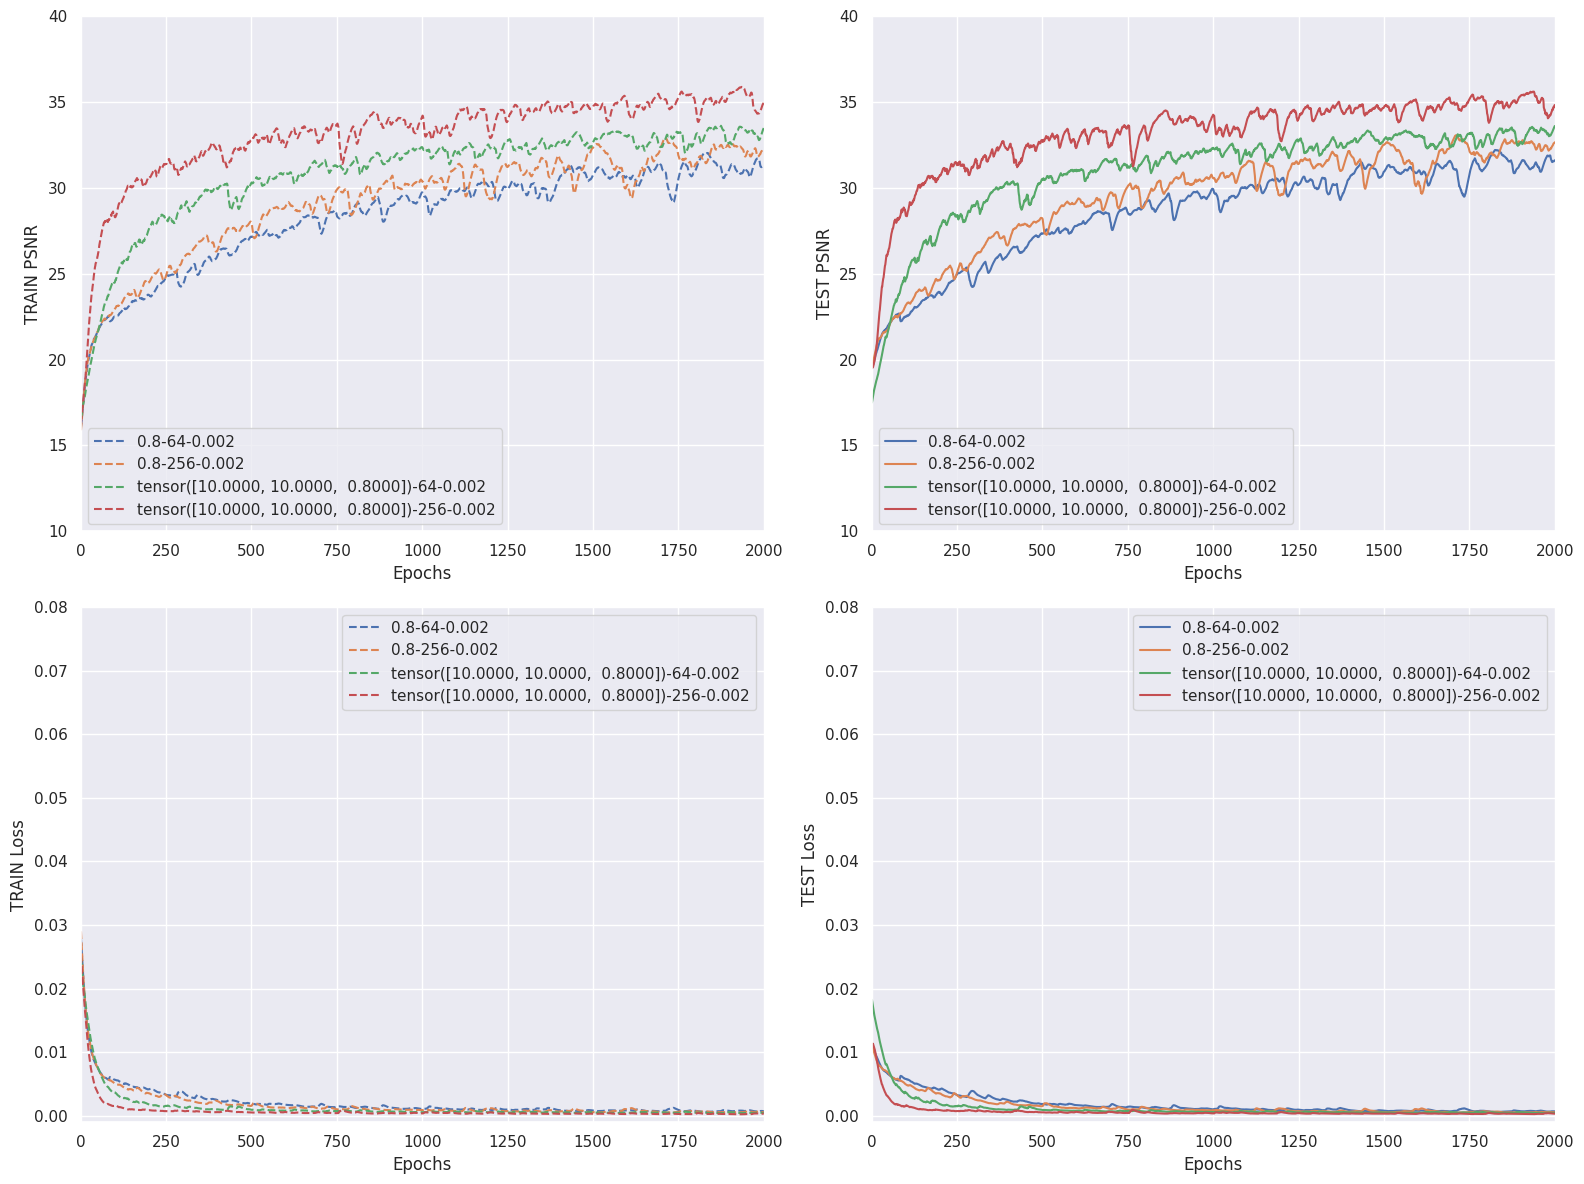

In [24]:
# from seaborn.relational import lineplot
# Set the Seaborn theme for better visualization
seaborn.set()
seaborn.set_theme()

# Create a figure and axes with two rows and two columns
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Generate x-values based on the number of epochs
xs = np.arange(1, config['EPOCHS'] + 1)

# Define metrics and their corresponding y-axis labels
metrics = ['psnr', 'test_psnr', 'loss', 'test_loss']
y_labels = ['TRAIN PSNR', 'TEST PSNR', 'TRAIN Loss', 'TEST Loss']

# Define y-axis limits for PSNR and Loss plots
y_limits = [(10, 40), (10, 40), (-0.001, 0.08), (-0.001, 0.08)]

# Loop through each subplot to plot the data
for i, ax in enumerate(axs.flatten()):
    metric = metrics[i]  # Get the metric to be plotted for this subplot
    # Set the line style based on the subplot index (even or odd)
    if (i % 2 == 0):
        line = '--'  # Dashed line for even-indexed subplots
    else:
        line = '-'  # Solid line for odd-indexed subplots

    y_label = y_labels[i]  # Get the y-axis label for this subplot
    y_min, y_max = y_limits[i]  # Get the y-axis limits for this subplot

    # Plot the smoothed curve for each dictionary in 'dics'
    for k in dics:
      #if k!='sigma_tensor':
        ax.plot(xs, smooth_curve(dics[k][metric], .94), label=k, linestyle=line)

    # Set subplot title, labels, and legend
    ax.set_title('')
    ax.set_ylabel(y_label)
    ax.set_xlabel('Epochs')
    ax.legend()

    # Adjust the axis limits
    ax.set_xlim(left=0)
    ax.set_xlim(right=2000)
    ax.set_ylim(bottom=0)

    # Adjust the position of the axes to start at the origin
    ax.spines['left'].set_position('zero')
    # ax.spines['bottom'].set_position('zero')

    # Remove the top and right spines for better visualization
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Set the y-axis limits based on the predefined values
    ax.set_ylim(y_min, y_max)


# Adjust the spacing between the plots to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

# Reset the plot settings to default
plt.rcdefaults()

### Save models

In [25]:
# Loop through each dictionary in 'dics' to save the corresponding model and dictionary
for i, s in enumerate(dics):
    # Save the model's state dictionary to a .pth file
    torch.save(models[s].state_dict(), MODEL_PATH + f"{i}_MODEL_SUPERFF_{s}.pth")

    # Save the entire dictionary to a .pth file
    torch.save(dics[s], MODEL_PATH + f"{i}_DIC_SUPERFF_{s}.pth")


### Outputs

#### Get the best generated images from each model

In [26]:
# Create models
m = 64
ff_model_08_64 = NeuralFieldFF(input_size=(2*m), hidden_layers=3)
ff_model_tensor_64 = NeuralFieldFF(input_size=(2*m), hidden_layers=3)
m = 256
ff_model_08_256 = NeuralFieldFF(input_size=(2*m), hidden_layers=3)
ff_model_tensor_256 = NeuralFieldFF(input_size=(2*m), hidden_layers=3)

# Load models
ff_model_08_256.load_state_dict(torch.load(MODEL_PATH + '1_MODEL_SUPERFF_0.8-256-0.002.pth',
                                    map_location=torch.device('cpu')))
ff_model_08_64.load_state_dict(torch.load(MODEL_PATH + '0_MODEL_SUPERFF_0.8-64-0.002.pth',
                                    map_location=torch.device('cpu')))
ff_model_tensor_256.load_state_dict(torch.load(MODEL_PATH + '3_MODEL_SUPERFF_tensor([10.0000, 10.0000,  0.8000])-256-0.002.pth',
                                    map_location=torch.device('cpu')))
ff_model_tensor_64.load_state_dict(torch.load(MODEL_PATH + '2_MODEL_SUPERFF_tensor([10.0000, 10.0000,  0.8000])-64-0.002.pth',
                                    map_location=torch.device('cpu')))


# Load the dictionary containing additional information and configuration for the model.
ff_dic_08_256 = torch.load(MODEL_PATH + '1_DIC_SUPERFF_0.8-256-0.002.pth',
                           map_location=torch.device('cpu'))
ff_dic_08_64 = torch.load(MODEL_PATH + '0_DIC_SUPERFF_0.8-64-0.002.pth',
                          map_location=torch.device('cpu'))
ff_dic_tensor_256 = torch.load(MODEL_PATH + '3_DIC_SUPERFF_tensor([10.0000, 10.0000,  0.8000])-256-0.002.pth',
                               map_location=torch.device('cpu'))
ff_dic_tensor_64 = torch.load(MODEL_PATH + '2_DIC_SUPERFF_tensor([10.0000, 10.0000,  0.8000])-64-0.002.pth',
                              map_location=torch.device('cpu'))


models = {}
models[f'σ=0.8 - k=128'] = ff_model_08_64
models[f'σ=0.8 - k=512'] = ff_model_08_256
models[f'σ=(10, 10, 0.8) - k=128'] = ff_model_tensor_64
models[f'σ=(10, 10, 0.8) - k=512'] = ff_model_tensor_256


dics = {}
dics[f'σ=0.8 - k=128'] = ff_dic_08_64
dics[f'σ=0.8 - k=512'] = ff_dic_08_256
dics[f'σ=(10, 10, 0.8) - k=128'] = ff_dic_tensor_64
dics[f'σ=(10, 10, 0.8) - k=512'] = ff_dic_tensor_256


In [27]:
import re

# Define the indices of the images to be used
im_index = [1, 11, 17]

# Initialize lists to store all generated images and labels, and ground truth images and labels
all_generated_images = []
all_lbl_gen = []

# Function to format numbers by converting strings that end with .0000 to a simpler form
def format_number(match):
  number = match.group(0)
  # Convert the string to a float and back to string, rounding to 1 significant decimal
  # if all additional decimals are zeros
  # This also reduces numbers like .8000 to .8, for example
  return str(float(number))

# Loop through each FF model stored in the 'models' dictionary
for s, model in models.items():
  # Set the model to evaluation mode
  model.eval()

  # Get the mapping matrix
  B_matrix = dics[s]['B']

  # Extract the configuration settings from the loaded dictionary.
  config = dics[s]['config']
  coords = config['COORDS_VAL']

  # Loop through each image index specified in 'im_index'
  for i in im_index:
    # Map coordinates with B Matrix
    ff_coords = fourier_mapping(coords[i].unsqueeze(0).to('cpu'), B_matrix)
    # Generate an image using the current FOURIER FEATURES model and the mapped coordinates
    img = model(ff_coords)

    # Append the generated image to the list of all generated images
    all_generated_images.append(img)

    # Create a label for the generated image indicating the model configuration and the wavelength
    all_lbl_gen.append(f'{s} - $\\lambda_{{{i + 1}}}$')

# Concatenate the generated images for plotting
all_generated_images = torch.cat(all_generated_images, dim=0).squeeze().detach().cpu().numpy()

# Select and prepare the ground truth images for plotting
gt_images_np = config['GT_IMG'][im_index].squeeze().detach().cpu().numpy()

# Create labels for the selected ground truth images
lbls_gt = [f'GT $\\lambda_{{{label + 1}}}$' for label in im_index]

# Combine all images and labels for plotting
all_images = np.concatenate([all_generated_images, gt_images_np], axis=0)
all_labels = all_lbl_gen + lbls_gt

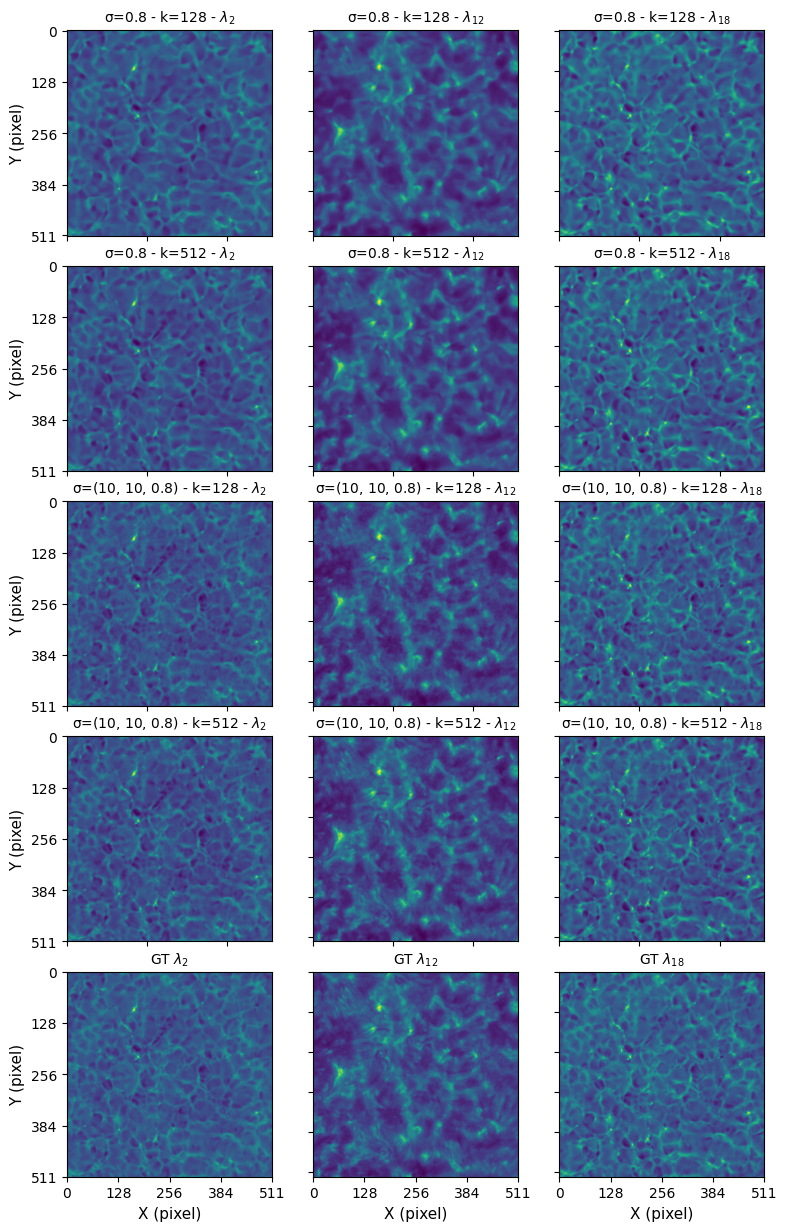

In [28]:
# Utilizes the 'plot_data' function from the 'utils' module to display the images.
# The images are arranged in a grid with 3 columns, and each image is labeled according to the 'labels' list.
plot_data(dataset=all_images, num_columns=len(im_index),
          labels=all_labels, tick_size=10,
          title_size=10, axis_size=11,
          path=IMAGES_PATH, img_name='generated_and_GT',
          hspace=0.1, wspace=0.2)